In [1]:
import os 
import pandas as pd
from scipy.stats import zscore
import seaborn as sns
import numpy as np
import math

In [2]:
chrom_size = {"chr15": 102531392, "chr16": 90354753, "chr17": 81195210, "chr18": 78077248}

def mat(contact_list, resolution, first_chr_size, second_chr_size):
    row_num = math.ceil(first_chr_size/resolution)
    col_num = math.ceil(second_chr_size/resolution)
    mat = np.zeros([row_num,col_num])
    for index,row in contact_list.iterrows():
        ind1 = int(row[0]/resolution)
        ind2 = int(row[1]/resolution)
        if not np.isnan(row[2]):
            mat[ind1,ind2] = row[2]
    return mat
def sym_mat(mat):
    mat_size = mat.shape[0]
    i_upper = np.triu_indices(mat_size, 1)
    i_lower = (i_upper[1],i_upper[0])
    mat[i_lower] = mat[i_upper]
    return mat
def norm_mat(mat):
    norm_ratio = np.sqrt(np.matmul(mat.mean(0).reshape(-1,1),mat.mean(0).reshape(1,-1)))
    norm_mat = mat/norm_ratio
    return norm_mat

In [3]:
oe_hic_mats = {}
for first_chr in np.arange(15,19):
    for second_chr in np.arange(first_chr,19):
        curr_contact_list = pd.read_csv("/project/compbio-lab/epigenomics/GM12878/Hi-C/oe_100000/chr" + str(first_chr) + "_chr" + str(second_chr) + ".txt",
                                        sep = "\t", header = None)
        oe_hic_mats[first_chr,second_chr] = mat(curr_contact_list,100000,chrom_size['chr'+str(first_chr)],
                                        chrom_size['chr'+str(second_chr)])
        if first_chr == second_chr:
            oe_hic_mats[first_chr,second_chr] = sym_mat(oe_hic_mats[first_chr,second_chr])

In [6]:
resolution = 100000
file_names = os.listdir("../genomic-assays/ChIP-seq/bin_" + str(resolution) + "/")
assays_df = pd.DataFrame()
for file in file_names:
    file_path = os.path.join("../genomic-assays/ChIP-seq/bin_" + str(resolution) + "/",file)
    assay_df = pd.read_csv(file_path, sep = "\t", header = None)
    assay_name = file.split(".")[0].split("-")[1]
    assay_df.columns = ["chr_name", "start", "end", assay_name]
    if assays_df.empty:
        assays_df = assay_df
    else:
        assays_df = pd.merge(assays_df, assay_df, on = ["chr_name", "start", "end"])
assays_df_zs = assays_df.copy()
assays_df_zs.iloc[:,3:] = assays_df_zs.iloc[:,3:].apply(zscore)
assays_names = assays_df.columns[3:]
assays_df = assays_df[(assays_df.iloc[:,3:] != 0).all(1)]

In [8]:
assays_df

,chr_name,start,end,H3K27me3,H3K79me2,DNase,H3K36me3,H3K4me1,H3K27ac,H3K9ac,H3K4me3,H2A,H3K9me3,H4K20me1,H3K4me2
0,chr1,0,1,0.026553,0.010866,0.017192,0.027430,0.012195,0.012597,0.023658,0.028707,0.015270,0.022515,0.026234,0.015195
2,chr1,2,3,0.024816,0.003768,0.031684,0.020217,0.051133,0.021426,0.018565,0.018455,0.034069,0.019122,0.027212,0.035769
5,chr1,5,6,0.057225,0.008071,0.469453,0.029628,0.034715,0.022692,0.037046,0.033846,0.043498,0.038646,0.066048,0.035021
6,chr1,6,7,0.024922,0.006641,0.020819,0.047580,0.017030,0.008082,0.020332,0.022521,0.022727,0.021265,0.033746,0.007598
7,chr1,7,8,0.207846,0.877132,0.619823,0.750826,0.489236,0.632821,0.779254,0.603414,0.364142,0.330402,0.488400,0.655245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30361,chrX,1548,1549,0.432109,0.750722,0.562698,0.521836,0.413140,0.516176,0.583217,0.731133,0.715590,1.302566,0.455281,0.493449
30362,chrX,1549,1550,0.520883,0.131111,0.474410,0.368558,0.334989,0.203289,0.326096,0.476968,0.396447,0.722989,0.426987,0.295916
30363,chrX,1550,1551,0.506338,0.109251,0.464050,0.293037,0.280579,0.179426,0.278632,0.391847,0.369952,0.748286,0.427740,0.218369
30364,chrX,1551,1552,0.365778,0.731948,0.730550,1.091746,0.474534,0.422841,0.454311,0.743694,0.518969,1.098978,0.490905,0.593273


In [7]:
valid_bins = {}
for chr_num in np.arange(15,19):
    HiC_filtered = np.where(np.sum(oe_hic_mats[chr_num,chr_num],axis=1)!=0)[0]
    ChIP_filtered = list(assays_df[assays_df['chr_name']=="chr"+str(chr_num)]['start'])
    both_filtered = list(set(HiC_filtered) & set(ChIP_filtered))
    valid_bins[chr_num] = both_filtered

assays = {}
for chr_num in np.arange(15,19):
    assays[chr_num] = assays_df[(assays_df['chr_name'] == 'chr' + str(chr_num)) & (assays_df['start'].isin(valid_bins[chr_num]))]

for first_chr in np.arange(15,19):
    for second_chr in np.arange(first_chr,19):
        oe_hic_mats[first_chr,second_chr] = oe_hic_mats[first_chr,second_chr][np.ix_(valid_bins[first_chr],valid_bins[second_chr])]

In [9]:
def spatial_correlation(signal,adj_mat):
    dim = len(signal)
    signal_mean = np.mean(signal)
    mat_sum = np.sum(adj_mat)
    frac_nom = 0
    frac_denom = 0
    for i in range(adj_mat.shape[0]):
        for j in range(adj_mat.shape[0]):
            frac_nom = frac_nom + (adj_mat[i,j] * (signal[i] - signal_mean) * (signal[j] - signal_mean))
        frac_denom = frac_denom + ((signal[i] - signal_mean) * (signal[i] - signal_mean))
    moran = frac_nom * dim / (mat_sum * frac_denom)
    return(moran)
def spatial_correlation2(signal1,signal2,adj_mat):  
    signal = signal1 + signal2
    signal_mean = np.mean(signal)
    signal_var = np.var(signal)
    mat_sum = np.sum(adj_mat)
    frac_nom = 0
    frac_denom = 0
    for i in range(adj_mat.shape[0]):
        for j in range(adj_mat.shape[1]):
            frac_nom = frac_nom + (adj_mat[i,j] * (signal1[i] - signal_mean) * (signal2[j] - signal_mean))
    moran = frac_nom / (mat_sum * signal_var)
    return(moran)

In [ ]:
s = spatial_correlation2(list(assays[15]['DNase']),list(assays[15]['DNase']),oe_hic_mats[15,15])

In [ ]:
def auto_corr(signal):
    corr_vals = []
    for t in np.arange(1,100):
        corr_val = np.corrcoef(signal[:-t],signal[t:])[0,1]
        corr_vals.append(corr_val)
    return(corr_vals)
def assign_chunk_num(signals_df):
    is_first_pos = [1]
    is_first_pos.extend([int(d1-d2 > 1) for d1,d2 in zip(signals_df['start'][1:] , signals_df['end'][:-1])])
    signals_df['chunk_num'] = np.cumsum(is_first_pos)
    return(signals_df)

In [66]:
assays_df = assays_df[(assays_df.iloc[:,3:] != 0).all(1)]
chr1_assays = assays_df[assays_df_zs['chr_name'] == "chr1"]
chr1_assays = assign_chunk_num(chr1_assays)
sample_chunk = chr1_assays[chr1_assays['chunk_num']==15]

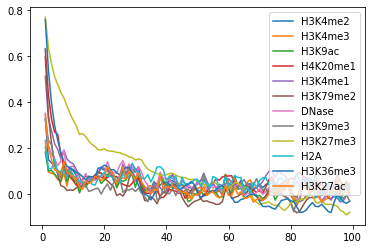

In [92]:
for assay in assays_names:
    acorr = auto_corr(sample_chunk[assay])
    sns.lineplot(x = np.arange(1,100), y = acorr, label = assay)